<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Aptos;text-align:center;display:fill;border-radius:5px;background-color:#00008B;overflow:hidden"><b>AI use cases & XAI techniques in Insurance</b></div>

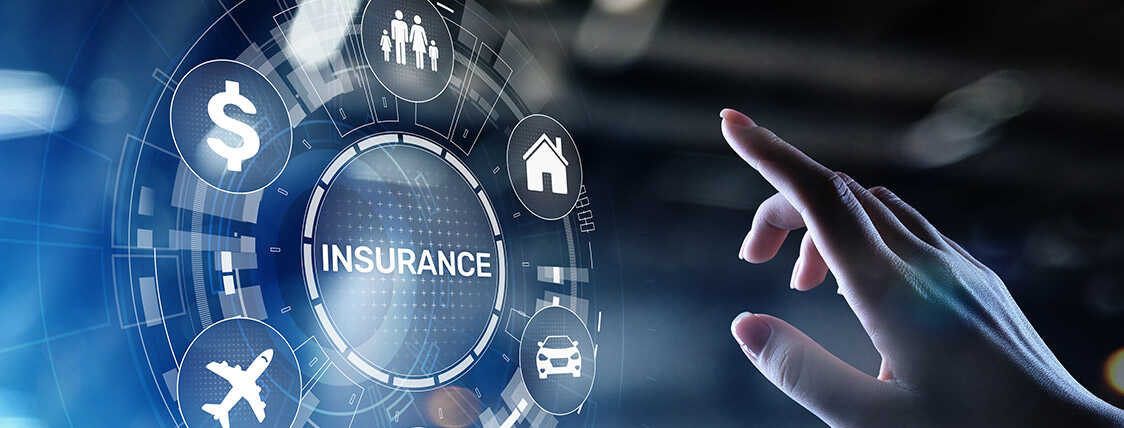

### **1. Initiate libraries and paths**

In [1]:
import PyPDF2
import pandas as pd
import numpy as np
from transformers import pipeline
import os
from glob import glob
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import re

# Folder paths for txt files
abstracts_folder = 'C:/Users/bart_/Documents/Ethical_AI/Assignment/Abstracts'
pdf_folder = 'C:/Users/bart_/Documents/Ethical_AI/Assignment/Literature'

c:\Users\bart_\anaconda3\envs\llms\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **2. Create word cloud**

In [2]:
# # Load text from all txt files
# abstract_texts = []
# for file in glob(os.path.join(abstracts_folder, "*.txt")):
#     with open(file, 'r', encoding='utf-8') as f:
#         abstract_texts.append(f.read())

# # Print the number of abstracts read
# print(f"Number of abstracts read: {len(abstract_texts)}")

# # Join all abstracts into one text for word cloud generation
# all_abstracts_text = " ".join(abstract_texts)

In [3]:
# # Generate word cloud
# wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(all_abstracts_text)

# # Save the word cloud as an image with high resolution
# plt.figure(figsize=(11.69, 8.27))  # A4 aspect ratio in inches (landscape orientation)
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.tight_layout(pad=0)
# plt.savefig("wordcloud.png", dpi=300, bbox_inches="tight")
# plt.show()

### **3. Word counter on words of interest**

In [4]:
# # Initiate empty dict
# pdf_texts = {}

# # Use glob to find all PDFs in subfolders
# for file in glob(os.path.join(pdf_folder, "**", "*.pdf"), recursive=True):
#     pdf_text = ""
#     with open(file, 'rb') as pdf_file:
#         pdf_reader = PyPDF2.PdfReader(pdf_file)
#         for page_num in range(len(pdf_reader.pages)):
#             pdf_text += pdf_reader.pages[page_num].extract_text()
    
#     # Extract the subfolder name
#     subfolder_name = os.path.basename(os.path.dirname(file))

#     # Store everything
#     pdf_texts[(os.path.basename(file), subfolder_name)] = pdf_text

In [5]:
# # List of insurance-related words
# word_dict = pd.read_excel('C:/Users/bart_/Documents/Ethical_AI/Assignment/Taxonomies.xlsx')

In [6]:
# interest_words = word_dict['Interest_word'].to_list()
# interest_words

In [7]:
# pdf_word_counts = []

# for (filename, subfolder), text in pdf_texts.items():
#     # Remove the '.pdf' extension
#     title = filename.replace('.pdf', '')

#     # Extract the publication year (last 4 characters)
#     publication_year = None
#     if len(title) >= 4 and title[-4:].isdigit():
#         publication_year = int(title[-4:])
#         # Remove the publication year from the title
#         title = title[:-4].strip()

#     # Convert text to lowercase
#     text_lower = text.lower()
#     count_data = {
#         'title': title,
#         'subdomain': subfolder,
#         'publication_year': publication_year}
    
#     # Count function
#     for term in interest_words:
#         if " " in term:  
#             count = len(re.findall(r'\b' + re.escape(term) + r'\b', text_lower))
#         else:  
#             count = text_lower.split().count(term)
        
#         count_data[term] = count
    
#     pdf_word_counts.append(count_data)

# df = pd.DataFrame(pdf_word_counts)

In [8]:
# XAI_techniques = word_dict[word_dict['Design'] == 'XAI_technique']['Interest_word'].to_list()

# df['XAI_used?'] = np.where(df[XAI_techniques].sum(axis=1) > 2,1,0)

In [9]:
#Optional: load the reviewed df
df = pd.read_excel('C:/Users/bart_/Documents/Ethical_AI/Assignment/Publication/Literature_review_publication.xlsx', sheet_name='reference_review')

In [10]:
df

,Unnamed: 0,class,review,title,subdomain,code,publication_year,logistic regression,linear regression,k-nearest neighbors,...,variable importance,ice,XAI_used?,Notes,Data type,LoB,Explanation by simplification,Feature relevance explanation,Visual explanation,Hybrid approach
0,1,used_in_assignment,1. include,A Comparison between Explainable Machine Learn...,Risk assessment,risk1,2023.0,0.0,0.0,0.0,...,0.0,0.0,1.0,Paper investigates several XAI techniques on t...,Tabular,life,NaN,1.0,NaN,NaN
1,2,used_in_assignment,1. include,A Deep Learning and Transfer Learning Approach...,Claims management,claims1,2021.0,0.0,0.0,0.0,...,0.0,0.0,0.0,Deep learning and transfer learning approach f...,image data,auto,NaN,NaN,NaN,NaN
2,3,used_in_assignment,1. include,A Deep Learning Model for Insurance Claims Pre...,Risk assessment,risk2,2024.0,0.0,0.0,0.0,...,0.0,0.0,0.0,"Here, various deep learning architectures are ...",Tabular,health,NaN,NaN,NaN,NaN
3,4,used_in_assignment,1. include,A deep-learning approach based antifraud syste...,Fraud detection,fraud1,2023.0,0.0,0.0,0.0,...,0.0,0.0,1.0,A deep-learning approach on car insurance clai...,image data,health,NaN,1.0,NaN,NaN
4,5,used_in_assignment,1. include,A hybrid model for detecing insurance fraud,Fraud detection,fraud2,2023.0,0.0,0.0,0.0,...,0.0,0.0,0.0,Combination of Kmeans clustering to make group...,tabular,auto,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,186,excluded,3. excluded,Towards explainability of machine learning mod...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266,187,excluded,3. excluded,Use of neural networks in risk assessment and ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,188,excluded,3. excluded,Utilizing Machine Learning for Dynamic Pricing...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,189,excluded,3. excluded,What Role for AI in Insurance Pricing,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df['XAI_used?'].sum()

53.0

In [12]:
# only keep the rows for the references we will keep for the research
df = df[df['review'] == '1. include']
df.shape

(125, 42)

### **4. Visualizations**

**4.1 References per publication year**

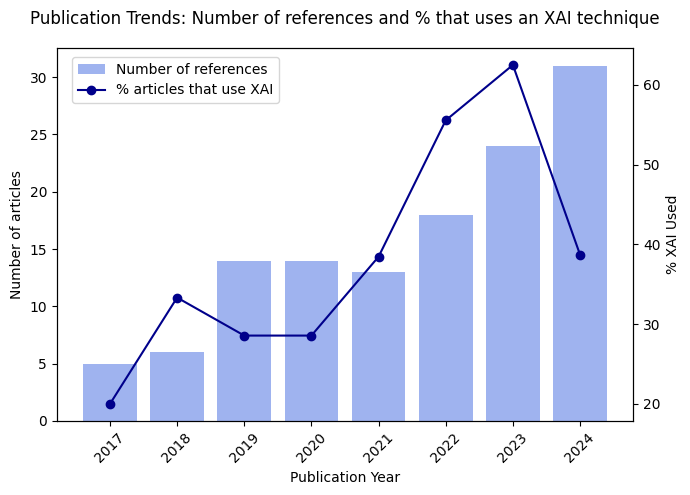

In [13]:
# Create the grouped view
grouped = df.groupby('publication_year').agg(title_count=('title', 'count'),xai_sum=('XAI_used?', 'sum')).reset_index()
grouped['xai_percentage'] = (grouped['xai_sum'] / grouped['title_count']) * 100

# Plot area
fig, ax1 = plt.subplots(figsize=(7, 5))

# Bar plot for count of articles
ax1.bar(grouped['publication_year'], grouped['title_count'], color='#4169E1', label='Number of references', alpha=0.5)
ax1.set_xlabel('Publication Year')
ax1.set_ylabel('Number of articles', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(grouped['publication_year'])
ax1.set_xticklabels(grouped['publication_year'].astype(int), rotation=45)

# Line plot for XAI usage
ax2 = ax1.twinx()
ax2.plot(grouped['publication_year'], grouped['xai_percentage'], color='darkblue', marker='o', label='% articles that use XAI')
ax2.set_ylabel('% XAI Used', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Figure settings
ax1.grid(False)
ax2.grid(False)
fig.suptitle('Publication Trends: Number of references and % that uses an XAI technique')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()

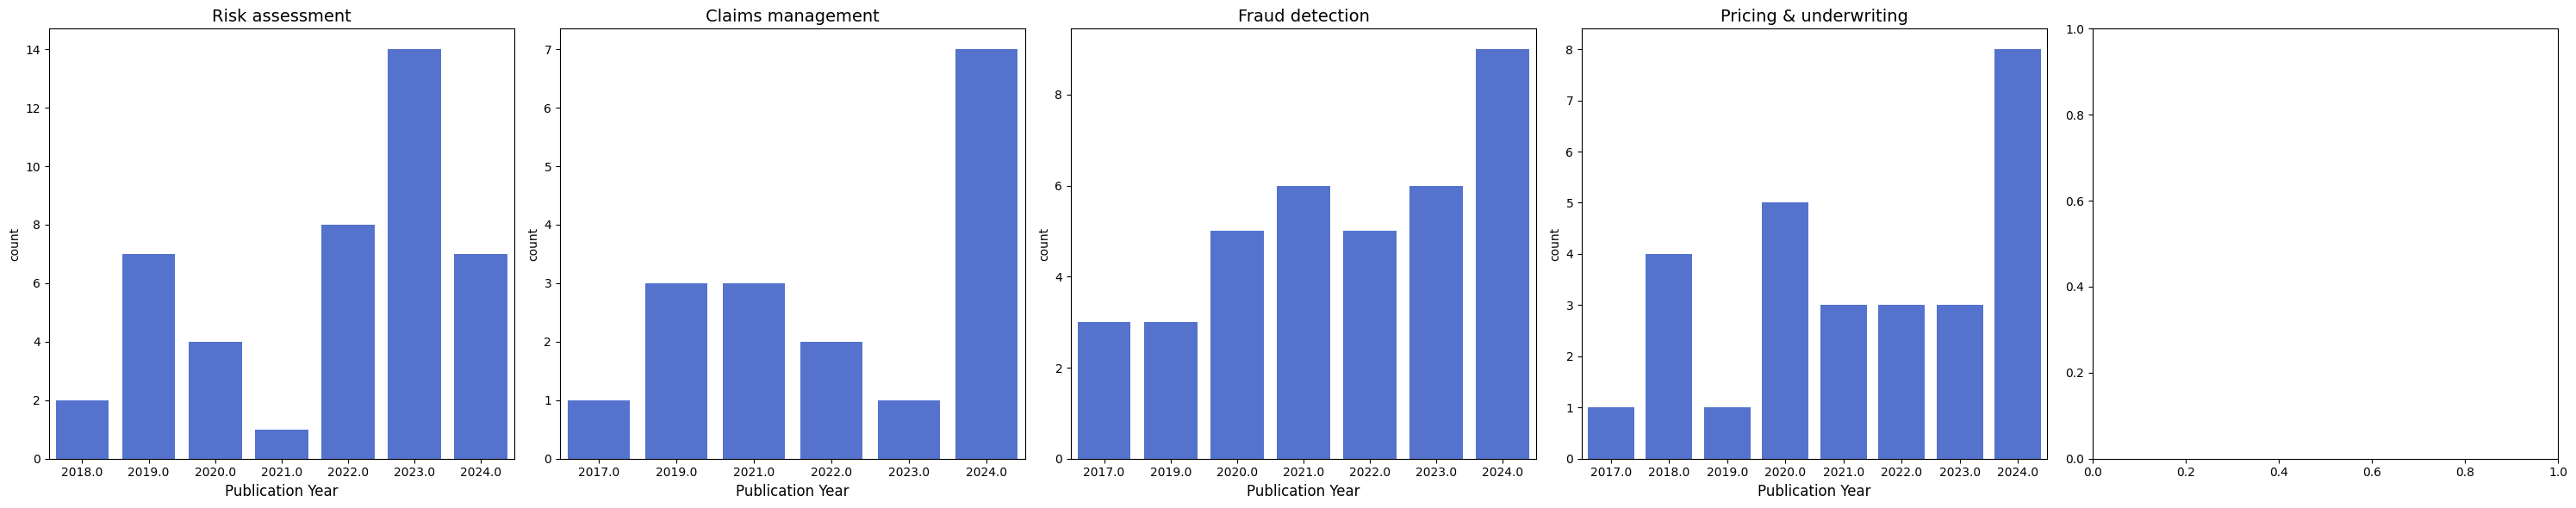

In [14]:
# Get unique subfolders
subdomains = df['subdomain'].unique()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 6),sharex=False, sharey=False)

# Iterate over subfolders and create a count plot for each
for ax, subdomain in zip(axes, subdomains):
    subset = df[df['subdomain'] == subdomain]
    
    sns.countplot(data=subset,x='publication_year',ax=ax,color='#4169E1',order=sorted(subset['publication_year'].unique()))
    
    ax.set_title(f'{subdomain}', fontsize=14)
    ax.set_xlabel('Publication Year', fontsize=12)

plt.tight_layout()
plt.show()

**4.2 References per subdomain**

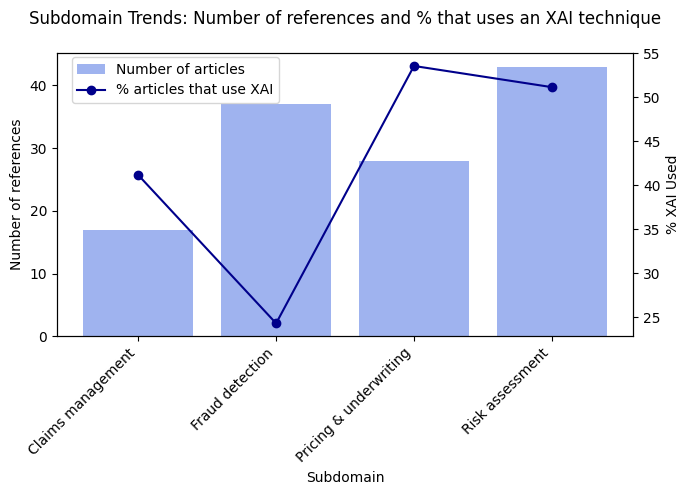

In [15]:
# Create the grouped view
grouped_subdomain = df.groupby('subdomain').agg(title_count=('title', 'count'),xai_sum=('XAI_used?', 'sum')).reset_index()
grouped_subdomain['xai_percentage'] = (grouped_subdomain['xai_sum'] / grouped_subdomain['title_count']) * 100

# Plot area
fig, ax1 = plt.subplots(figsize=(7, 5))

# Bar plot for count of articles
ax1.bar(grouped_subdomain['subdomain'], grouped_subdomain['title_count'], color='#4169E1', label='Number of articles', alpha=0.5)
ax1.set_xlabel('Subdomain')
ax1.set_ylabel('Number of references', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(grouped_subdomain['subdomain'])
ax1.set_xticklabels(grouped_subdomain['subdomain'], rotation=45, ha='right')

# Line plot for XAI usage
ax2 = ax1.twinx()
ax2.plot(grouped_subdomain['subdomain'], grouped_subdomain['xai_percentage'], color='darkblue', marker='o', label='% articles that use XAI')
ax2.set_ylabel('% XAI Used', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Figure settings
ax1.grid(False)
ax2.grid(False)
fig.suptitle('Subdomain Trends: Number of references and % that uses an XAI technique')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()

**4.3 Heatmap of AI and XAI techniques**

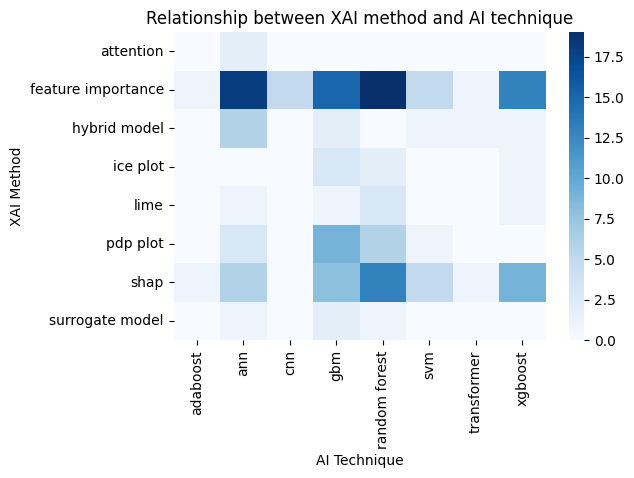

In [16]:
# Define AI and XAI techniques
word_dict = pd.melt(df, id_vars=['title'], var_name='Interest_word', value_name='Count')
word_dict['Design'] = word_dict['Interest_word'].apply(
    lambda x: 'Post-hoc explainability' if x in [
        'random forest', 'xgboost','adaboost','gbm', 'ann', 'cnn', 'svm', 
        'genetic algorithm', 'reinforcement learning', 'transformer', 
    ] else ('XAI_technique' if x in [
        'lime', 'shap', 'partial dependence plots','attention',
        'feature importance', 'surrogate model', 'variable importance', 'ice', 'hybrid model'
    ] else 'Other')
)

AI_techniques = word_dict[word_dict['Design'] == 'Post-hoc explainability']['Interest_word'].unique().tolist()
XAI_techniques = word_dict[word_dict['Design'] == 'XAI_technique']['Interest_word'].unique().tolist()

filtered_df = df[['title'] + AI_techniques + XAI_techniques]

# Reshape the df
melted_df = pd.melt(filtered_df, id_vars=['title'], var_name='Technique', value_name='Count')
melted_df = melted_df[melted_df['Count'] > 0]

# Separate AI and XAI techniques
melted_df['Category'] = melted_df['Technique'].apply(lambda x: 'AI' if x in AI_techniques else 'XAI')

# Create AI-XAI combinations
ai_xai_combinations = melted_df.pivot_table(index='title', columns='Category', values='Technique', aggfunc=lambda x: list(x)).dropna()

# Explode to create all combinations of AI and XAI techniques for each title
ai_xai_combinations = ai_xai_combinations.explode('AI').explode('XAI').dropna().reset_index()

# Map similar XAI techniques
xai_mapping = {
    'shapley': 'shap',
    'shap': 'shap',
    'partial dependence plots': 'pdp plot',
    'pdp': 'pdp plot',
    'ice': 'ice plot',
    'variable importance':'feature importance'
}
ai_xai_combinations['XAI'] = ai_xai_combinations['XAI'].replace(xai_mapping)

# Counts
heatmap_data = ai_xai_combinations.groupby(['XAI', 'AI']).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=False, cmap='Blues', cbar=True, fmt='d')
plt.title('Relationship between XAI method and AI technique')
plt.xlabel('AI Technique')
plt.ylabel('XAI Method')
plt.show()

**4.4 XAI taxonomies**

In [17]:
df_aggregated = df.pivot_table(index='subdomain', values=['Explanation by simplification','Feature relevance explanation','Visual explanation','Hybrid approach'], aggfunc='sum', fill_value=0)

# Reset index for plotting
df_aggregated = df_aggregated.reset_index()

df_aggregated.head()

,subdomain,Explanation by simplification,Feature relevance explanation,Hybrid approach,Visual explanation
0,Claims management,0.0,2.0,0.0,5.0
1,Fraud detection,2.0,7.0,1.0,0.0
2,Pricing & underwriting,3.0,12.0,3.0,6.0
3,Risk assessment,2.0,19.0,2.0,6.0


C:\Users\bart_\AppData\Local\Temp\ipykernel_16740\796819311.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Blues")


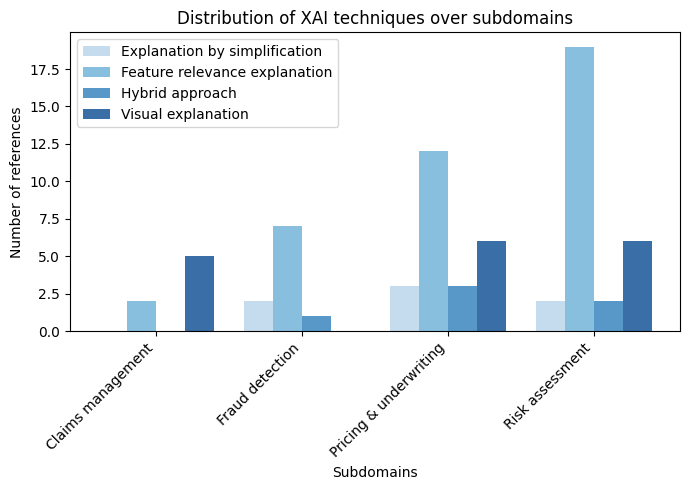

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Plot settings
x = np.arange(len(df_aggregated['subdomain']))  # the label locations
width = 0.2  # the width of the bars

# Use 'Blues' colormap, focusing on the darker range (avoid light colors)
cmap = cm.get_cmap("Blues")
colors = [mcolors.rgb2hex(cmap(0.3 + i * 0.2)) for i in range(len(df_aggregated.columns[1:]))]

# Assign colors dynamically
category_names = df_aggregated.columns[1:]  # Exclude 'Subdomain'
category_colors = dict(zip(category_names, colors))

# Create the plot area
fig, ax = plt.subplots(figsize=(7, 5))

# Plot each category dynamically
for i, category in enumerate(category_names):
    ax.bar(x + (i - 1.5) * width, df_aggregated[category], width, 
           label=category, color=category_colors[category], alpha=0.8)

# Chart layout
ax.set_xlabel('Subdomains')
ax.set_ylabel('Number of references')
ax.set_title('Distribution of XAI techniques over subdomains')
ax.set_xticks(x)
ax.set_xticklabels(df_aggregated['subdomain'], rotation=45, ha="right")
ax.legend()

fig.tight_layout()
plt.show()

**4.5 Sankey plot**

In [19]:
import plotly.graph_objects as go

In [ ]:
data = ai_xai_combinations.groupby(["XAI", "AI"], as_index=False)["title"].count()
xai_total_values = data.groupby("XAI")["title"].sum().sort_values(ascending=False)
sorted_xai_labels = xai_total_values.index.tolist()
unique_ai_labels = [label for label in pd.concat([data["XAI"], data["AI"]]).unique() if label not in sorted_xai_labels]
sorted_labels = sorted_xai_labels + unique_ai_labels
label_map = {label: i for i, label in enumerate(sorted_labels)}
data["source_idx"] = data["XAI"].map(label_map)
data["target_idx"] = data["AI"].map(label_map)

xai_palette = sns.color_palette("viridis", n_colors=len(sorted_xai_labels))

xai_color_map = {xai: "rgba({}, {}, {}, 0.8)".format(
    int(r * 255), int(g * 255), int(b * 255)) for xai, (r, g, b) in zip(sorted_xai_labels, xai_palette)}

link_colors = [xai_color_map[source] for source in data["XAI"]]

node_colors = [
    xai_color_map[label] if label in xai_color_map else "#ffffff"  
    for label in sorted_labels
]

fig = go.Figure(go.Sankey(
    node=dict(
        pad=15, thickness=20, line=dict(color="black", width=0.5),  
        label=sorted_labels, color=node_colors
    ),
    link=dict(
        source=data["source_idx"], 
        target=data["target_idx"],  
        value=data["title"],
        color=link_colors
    )
))

fig.update_layout(
    title=dict(
        text="Relationship between XAI method and AI technique",
        font=dict(family="Calibri", size=18, color="#2b2d42"),  # Dark text
        x=0.5,  # Center title
        y=0.95
    ),
    font=dict(family="Calibri", size=14, color="#2b2d42"),  # Dark text
    paper_bgcolor="#ffffff",  # White background
    plot_bgcolor="#ffffff",  
    margin=dict(l=50, r=50, t=80, b=50),
    width=600, 
    height=800   
)

fig.show()